In [1]:
!date

Mon Aug 18 10:38:05 PM EDT 2025


In [2]:
pwd

'/projects/sccn/andromeda1/aglinska/BC-ABCD-denoise/Code'

In [3]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import ants

In [4]:
from DeepCor_utils import *
from DeepCor_models import *

numpy version: 1.20.1
sklearn version: 1.3.2
torch version: 2.4.1+cu121
AntsPy version: 0.6.1


In [5]:
from tqdm import tqdm

In [22]:
subs = [f for f in os.listdir('../Data/StudyForrest/ROIs/') if f.startswith('rFFA') and f.endswith('.gz')]
subs = [val.replace('rFFA_final_mask_','').replace('_bin.nii.gz','') for val in subs]
subs.sort()

In [76]:
s = 0
r = 1
kind = 'compcor'

def get_roi_data(s,r,kind):
    indir = '../Data/StudyForrest/ensembles_last_CVAE/DeepCor-forrest-v4-beta-1e-5/'
    #indir = '../Data/StudyForrest/ensembles_last_CVAE/refactored-forrest-v3'
    roi_fn = f'../Data/StudyForrest/ROIs/rFFA_final_mask_{subs[s]}_bin.nii.gz'
    fn = f'contrast_face_{s}_R{r}_{kind}.nii.gz'
    im = ants.image_read(os.path.join(indir,fn))
    roi = ants.image_read(roi_fn)
    return im.numpy()[roi.numpy()==1]

In [77]:
def get_rel(s,kind):
    v1 = np.array([get_roi_data(s,r,kind) for r in [1,2]]).mean(axis=0)
    v2 = np.array([get_roi_data(s,r,kind) for r in [3,4]]).mean(axis=0)
    r = np.corrcoef(v1,v2)[0,1]
    return r

In [78]:
rel1=np.array([get_rel(s,'preproc') for s in range(14) ])
rel2=np.array([get_rel(s,'compcor') for s in range(14) ])
rel3=np.array([get_rel(s,'deepcor') for s in range(14) ])

print(rel1.mean())
print(rel2.mean())
print(rel3.mean())

0.6250378938139639
0.6394415808694035
0.4973083839188338


In [20]:
def get_betas(Y,X1):
    
    Y = (Y-Y.mean(axis=1)[:,np.newaxis])/Y.std(axis=1)[:,np.newaxis] # Z score values
    Y = Y.transpose()
    X = X1.values
    beta = np.linalg.inv(X.T @ X1) @ X1.T @ Y
    beta = beta.T
    beta = beta.values
    return beta

In [206]:
from scipy.spatial.distance import pdist,squareform
from scipy.stats import ttest_rel

In [86]:
indir = '../Data/StudyForrest/ensembles_last_CVAE/refactored-forrest-v3'

In [79]:
s = 0
r = 1

In [80]:
sub = subs[s]

In [164]:
def get_rdm_preproc(s,r,kind='preproc'):
    if kind=='preproc':
        fn = os.path.join(indir,f'preproc_S{s}_R{r}.nii.gz')
    elif kind=='compcor':
        fn = os.path.join(indir,f'compcor_S{s}_R{r}.nii.gz')
    elif kind=='deepcor':
        fn = os.path.join(indir,f'signal_S{s}_R{r}_avg.nii.gz')
    epi = ants.image_read(fn)
    
    roi_fn = f'../Data/StudyForrest/ROIs/rFFA_final_mask_{subs[s]}_bin.nii.gz'
    roi = ants.image_read(roi_fn)
    
    events_fn = os.path.join(f'../Data/StudyForrest/events/{sub}_ses-localizer_task-objectcategories_run-{r}_events.tsv')
    X1 = get_design_matrix(epi,events_fn)
    
    roi_vec = epi.numpy()[roi.numpy()==1]
    roi_vec = roi_vec[roi_vec.std(axis=-1)>1e-3,:]
    rdm = pdist(get_betas(roi_vec,X1)[:,0:5].transpose(),metric='euclidean')

    return rdm

In [171]:
def get_rel_sub(s,kind):
    v1 = np.array([get_rdm_preproc(s,r,kind=kind) for r in [1,2]]).mean(axis=0)
    v2 = np.array([get_rdm_preproc(s,r,kind=kind) for r in [3,4]]).mean(axis=0)
    r = np.corrcoef(v1,v2)[0,1]
    return r

In [172]:
rel_preproc = np.array([get_rel_sub(s,'preproc') for s in range(14)])
rel_compcor = np.array([get_rel_sub(s,'compcor') for s in tqdm(range(14))])
rel_deepcor = np.array([get_rel_sub(s,'deepcor') for s in tqdm(range(14))])

In [177]:
rel_preproc.mean()

0.6302191027656239

In [178]:
rel_compcor.mean()

0.7739332365719817

In [179]:
rel_deepcor.mean()

0.7047411538179376

In [ ]:
rdms_preproc = [np.array([get_rdm_preproc(s,r,kind='preproc') for r in [1,2,3,4]]).mean(axis=0) for s in tqdm(range(14))]
rdms_compcor = [np.array([get_rdm_preproc(s,r,kind='compcor') for r in [1,2,3,4]]).mean(axis=0) for s in tqdm(range(14))]
rdms_deepcor = [np.array([get_rdm_preproc(s,r,kind='deepcor') for r in [1,2,3,4]]).mean(axis=0) for s in tqdm(range(14))]

In [186]:
rdms_preproc = np.array(rdms_preproc)
rdms_compcor = np.array(rdms_compcor)
rdms_deepcor = np.array(rdms_deepcor)

In [189]:
rdms_preproc_m = rdms_preproc.mean(axis=0)
rdms_compcor_m = rdms_compcor.mean(axis=0)
rdms_deepcor_m = rdms_deepcor.mean(axis=0)

In [195]:
rel_preproc = np.array([np.corrcoef(rdms_preproc[s,:],rdms_preproc_m)[0,1] for s in range(14)])
rel_compcor = np.array([np.corrcoef(rdms_compcor[s,:],rdms_compcor_m)[0,1] for s in range(14)])
rel_deepcor = np.array([np.corrcoef(rdms_deepcor[s,:],rdms_deepcor_m)[0,1] for s in range(14)])

In [197]:
rel_preproc.mean()

0.8389832709044074

In [198]:
rel_compcor.mean()

0.8833896432226893

In [199]:
rel_deepcor.mean()

0.8556232897884914

In [ ]:
### ABCD data

In [278]:
indir = '../Data/020-fmriprepped'
subs = [s for s in os.listdir(indir) if all((s.startswith('sub'),not s.endswith('.html')))]
subs.sort()
print(f'{s}/{len(subs)}')
n_orig = len(subs)
sub = subs[s]

0/34


In [279]:
indir = '../Data/StudyForrest/ensembles_last_CVAE/refactored-ABCD-v5-nopreclean'

In [329]:
def get_rdm_preproc(s,r,kind='preproc'):
    if kind=='preproc':
        fn = os.path.join(indir,f'preproc_S{s}_R{r}.nii.gz')
    elif kind=='compcor':
        fn = os.path.join(indir,f'compcor_S{s}_R{r}.nii.gz')
    elif kind=='deepcor':
        fn = os.path.join(indir,f'signal_S{s}_R{r}_avg.nii.gz')
        
    epi = ants.image_read(fn)
    
    roi_fn = f'../Data/ABCD-indiv-ROIs/FFA-ROI-S{s}.nii'
    
    roi = ants.image_read(roi_fn)
    sub = subs[s]
    #events_fn = os.path.join(f'../Data/StudyForrest/events/{sub}_ses-localizer_task-objectcategories_run-{r}_events.tsv')
    events_fn = os.path.join(f'../Data/011-ABCD-events/{sub}_ses-baselineYear1Arm1_task-nback_run-0{r}_events.tsv')
    X1 = get_design_matrix(epi,events_fn)
    
    roi_vec = epi.numpy()[roi.numpy()==1]
    roi_vec = roi_vec[roi_vec.std(axis=-1)>1e-3,:]
    rdm = pdist(get_betas(roi_vec,X1)[:,0:8].transpose(),metric='euclidean')
    return rdm

In [ ]:
# rdms_preproc = [np.array([get_rdm_preproc(s,r,kind='preproc') for r in [1,2]]).mean(axis=0) for s in tqdm(range(33))]
# rdms_compcor = [np.array([get_rdm_preproc(s,r,kind='compcor') for r in [1,2]]).mean(axis=0) for s in tqdm(range(33))]
# rdms_deepcor = [np.array([get_rdm_preproc(s,r,kind='deepcor') for r in [1,2]]).mean(axis=0) for s in tqdm(range(33))]

In [ ]:
rdms_preproc = [np.array([get_rdm_preproc(s,r,kind='preproc') for r in [1,2]]) for s in tqdm(range(33))]
rdms_compcor = [np.array([get_rdm_preproc(s,r,kind='compcor') for r in [1,2]]) for s in tqdm(range(33))]
rdms_deepcor = [np.array([get_rdm_preproc(s,r,kind='deepcor') for r in [1,2]]) for s in tqdm(range(33))]

In [288]:
rdms_preproc = np.array(rdms_preproc)
rdms_compcor = np.array(rdms_compcor)
rdms_deepcor = np.array(rdms_deepcor)

In [304]:
split_half_preproc = np.array([np.corrcoef(rdms_preproc[s,0,:],rdms_preproc[s,1,:])[0,1] for s in np.arange(33)])
split_half_compcor = np.array([np.corrcoef(rdms_compcor[s,0,:],rdms_compcor[s,1,:])[0,1] for s in np.arange(33)])
split_half_deepcor = np.array([np.corrcoef(rdms_deepcor[s,0,:],rdms_deepcor[s,1,:])[0,1] for s in np.arange(33)])

In [305]:
print(split_half_preproc.mean())
print(split_half_compcor.mean())
print(split_half_deepcor.mean())

0.1637905853404335
0.2613034763418484
0.22714480867957657


In [307]:
split_half_compcor

array([-0.26558226,  0.31035926, -0.16115156,  0.65595748,  0.22790063,
        0.50707534,  0.42747311,  0.58530282,  0.48178144,  0.74020559,
        0.75203692,  0.43797631,  0.54234278,  0.34512729,  0.3489318 ,
       -0.02054856,  0.26852426,  0.19627733, -0.25993444, -0.3060226 ,
        0.30569447, -0.12713988,  0.39473279,  0.48095973,  0.16485442,
        0.01385627,  0.0097057 ,  0.11771365, -0.0409619 ,  0.69072615,
       -0.08489607,  0.40913103,  0.47460539])

In [309]:
rdms_preproc_m = rdms_preproc.mean(axis=0).mean(axis=0)
rdms_compcor_m = rdms_compcor.mean(axis=0).mean(axis=0)
rdms_deepcor_m = rdms_deepcor.mean(axis=0).mean(axis=0)

rel_preproc = np.array([np.corrcoef(rdms_preproc[s,:,:],rdms_preproc_m)[0,1] for s in range(33)])
rel_compcor = np.array([np.corrcoef(rdms_compcor[s,:,:],rdms_compcor_m)[0,1] for s in range(33)])
rel_deepcor = np.array([np.corrcoef(rdms_deepcor[s,:,:],rdms_deepcor_m)[0,1] for s in range(33)])

print(rel_preproc.mean())
print(rel_compcor.mean())
print(rel_deepcor.mean())

0.1637905853404335
0.2613034763418484
0.22714480867957657


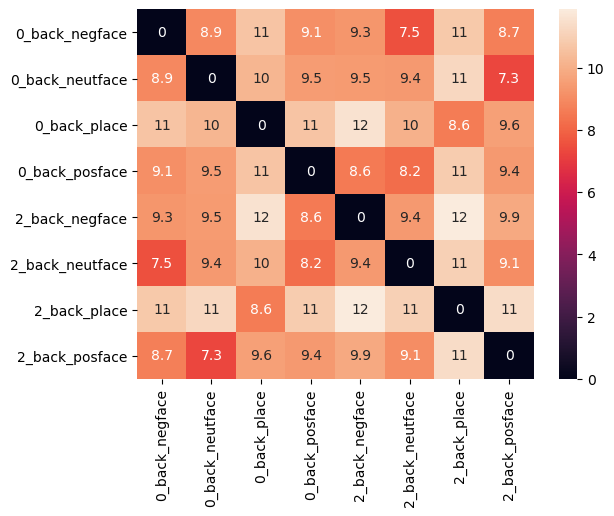

In [313]:
import seaborn as sns
sns.heatmap(squareform(rdms_preproc_m),annot=True)
plt.xticks(np.arange(8)+.5,list(X1.columns[0:8]),rotation=90);
plt.yticks(np.arange(8)+.5,list(X1.columns[0:8]),rotation=0);

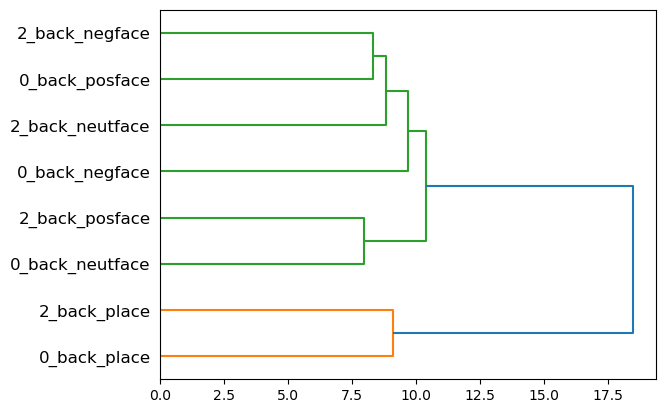

In [327]:
from scipy.cluster.hierarchy import linkage,dendrogram
Z = linkage(rdms_deepcor_m, 'ward')
plt.figure()
dn = dendrogram(Z,labels=list(X1.columns[0:8]),orientation='right')

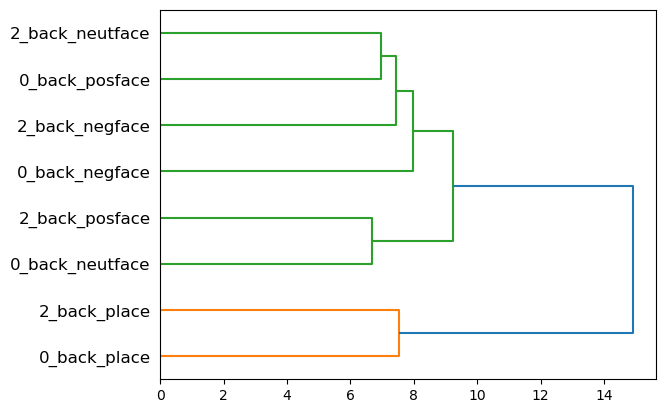

In [328]:
from scipy.cluster.hierarchy import linkage,dendrogram
Z = linkage(rdms_compcor_m, 'ward')
plt.figure()
dn = dendrogram(Z,labels=list(X1.columns[0:8]),orientation='right')

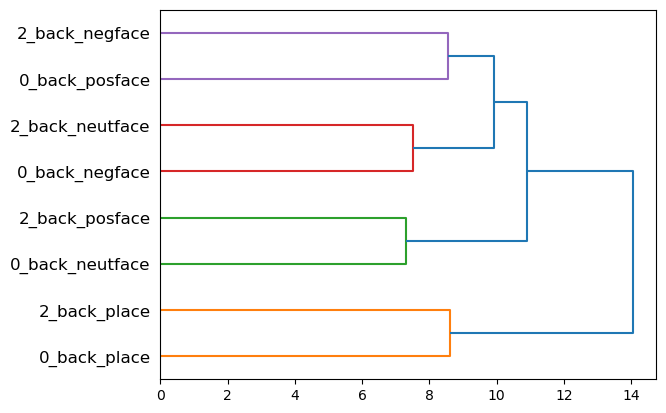

In [326]:
from scipy.cluster.hierarchy import linkage,dendrogram
Z = linkage(rdms_preproc_m, 'ward')
plt.figure()
dn = dendrogram(Z,labels=list(X1.columns[0:8]),orientation='right')

In [6]:
def correlate_columns(arr1, arr2):
    """
    Computes the Pearson correlation between corresponding columns of two matrices.
    
    Parameters:
    arr1 (np.ndarray): First matrix of shape (370, 1000)
    arr2 (np.ndarray): Second matrix of shape (370, 1000)
    
    Returns:
    np.ndarray: 1D array of correlations for each column (size 1000)
    """
    # Ensure input arrays are numpy arrays
    arr1 = np.asarray(arr1)
    arr2 = np.asarray(arr2)
    
    # Subtract the mean of each column (normalize)
    arr1_centered = arr1 - np.mean(arr1, axis=0)
    arr2_centered = arr2 - np.mean(arr2, axis=0)
    
    # Compute the numerator (covariance)
    numerator = np.sum(arr1_centered * arr2_centered, axis=0)
    
    # Compute the denominator (product of standard deviations)
    denominator = np.sqrt(np.sum(arr1_centered**2, axis=0) * np.sum(arr2_centered**2, axis=0))
    
    # Compute the Pearson correlation for each column
    correlation = numerator / denominator
    
    return correlation

In [8]:
def get_rdm_preproc(s,r,kind='preproc'):
    if kind=='preproc':
        fn = os.path.join(indir,f'preproc_S{s}_R{r}.nii.gz')
    elif kind=='compcor':
        fn = os.path.join(indir,f'compcor_S{s}_R{r}.nii.gz')
    elif kind=='deepcor':
        fn = os.path.join(indir,f'signal_S{s}_R{r}_avg.nii.gz')
        
    epi = ants.image_read(fn)
    
    roi_fn = f'../Data/ABCD-indiv-ROIs/FFA-ROI-S{s}.nii'
    
    roi = ants.image_read(roi_fn)
    sub = subs[s]
    #events_fn = os.path.join(f'../Data/StudyForrest/events/{sub}_ses-localizer_task-objectcategories_run-{r}_events.tsv')
    events_fn = os.path.join(f'../Data/011-ABCD-events/{sub}_ses-baselineYear1Arm1_task-nback_run-0{r}_events.tsv')
    X1 = get_design_matrix(epi,events_fn)
    
    roi_vec = epi.numpy()[roi.numpy()==1]
    roi_vec = roi_vec[roi_vec.std(axis=-1)>1e-3,:]
    return get_betas(roi_vec,X1)[:,0:8]
    #rdm = pdist(get_betas(roi_vec,X1)[:,0:8].transpose(),metric='euclidean')
    #return rdm

In [21]:
indir = '../Data/020-fmriprepped'
subs = [s for s in os.listdir(indir) if all((s.startswith('sub'),not s.endswith('.html')))]
subs.sort()
n_orig = len(subs)

In [22]:
indir = '../Data/StudyForrest/ensembles_last_CVAE/refactored-ABCD-v5-nopreclean'

In [ ]:
voxel_rel_preproc = [correlate_columns(get_rdm_preproc(s,1,kind='preproc').transpose(),get_rdm_preproc(s,2,kind='preproc').transpose()).mean() for s in tqdm(np.arange(33))]
voxel_rel_compcor = [correlate_columns(get_rdm_preproc(s,1,kind='compcor').transpose(),get_rdm_preproc(s,2,kind='compcor').transpose()).mean() for s in tqdm(np.arange(33))]
voxel_rel_deepcor = [correlate_columns(get_rdm_preproc(s,1,kind='deepcor').transpose(),get_rdm_preproc(s,2,kind='deepcor').transpose()).mean() for s in tqdm(np.arange(33))]

In [27]:
np.array(voxel_rel_preproc).mean()

0.18507580542476648

In [28]:
np.array(voxel_rel_compcor).mean()

0.3147502498437812

In [29]:
np.array(voxel_rel_deepcor).mean()

0.2912913703325377

In [40]:
from scipy.stats import ttest_rel

In [42]:
ttest_rel(voxel_rel_deepcor,voxel_rel_preproc)

Ttest_relResult(statistic=3.3852388198606245, pvalue=0.0018962945968218567)

In [41]:
ttest_rel(voxel_rel_deepcor,voxel_rel_compcor)

Ttest_relResult(statistic=-0.9943982399825225, pvalue=0.327489302464571)

In [38]:
np.vstack([voxel_rel_compcor,voxel_rel_deepcor])[:,0:5]

array([[ 0.142313  ,  0.3868778 ,  0.05305613,  0.3821584 ,  0.09291311],
       [ 0.14738439,  0.34099983, -0.02598362,  0.11458095,  0.11957035]])

(array([3., 3., 6., 3., 5., 3., 3., 3., 2., 2.]),
 array([-0.06252585,  0.01768032,  0.09788649,  0.17809267,  0.25829884,
         0.33850502,  0.41871119,  0.49891737,  0.57912354,  0.65932972,
         0.73953589]),
 <BarContainer object of 10 artists>)

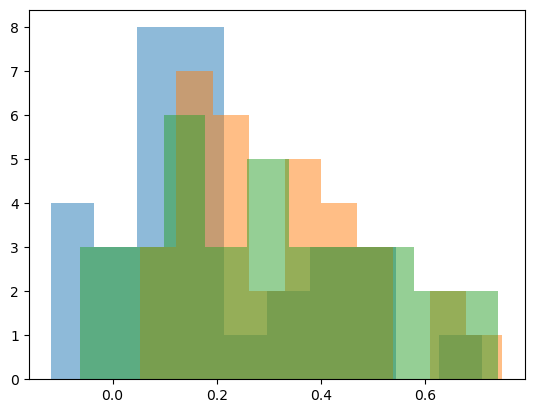

In [32]:
plt.hist(voxel_rel_preproc,alpha=.5)
plt.hist(voxel_rel_compcor,alpha=.5)
plt.hist(voxel_rel_deepcor,alpha=.5)